# Pedestrian Motion Prediction

## Libraries

In [30]:
%matplotlib inline
from collections import defaultdict
import numpy as np # For numerical calculations
import pandas as pd # For handling the data 
import xml.etree.ElementTree as ET # To parse XML files
from statsmodels.tsa.stattools import adfuller # For Dickey-Fuller Stationarity Test
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot

import seaborn as sns
import matplotlib.pyplot as plt # For plotting

In [2]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Dense, LSTM, Dropout, Masking
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize
import math

C:\Users\Amina Lejla\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
plt.rcParams['figure.figsize'] = [15, 7] # For bigger plots
plt.style.use('fivethirtyeight') # Special style template for matplotlib, highly useful for visualizing time series data

## Parsing the XML Files

In [4]:
network_file_path = 'sumo_pedestrian_simulation/osm.net.xml'
output_file_path = 'fcd-output.xml'

Parse the network xml file to obtain the min and max values for x and y

In [5]:
tree = ET.parse(network_file_path) # Open the network XML file
root = tree.getroot() # Get the root of the file
convBoundary = root[0].attrib['convBoundary'] # Get the convBoundary attribute of the location tag
x_min, y_min, x_max, y_max = map(lambda x: float(x), convBoundary.split(',')) # Get the min and max by splitting the convBoundary stringing
print('X_min = {}, X_max = {}, Y_min = {}, Y_max = {}'.format(x_min, x_max, y_min, y_max))

X_min = 0.0, X_max = 2512.95, Y_min = 0.0, Y_max = 1576.61


Parse the fcd output file to obtain the coordinates of the pedestrians

In [6]:
# Create an empty dataframe and then fill it up with values from the xml file
columns = ['time', 'id', 'x', 'y', 'angle', 'speed', 'pos', 'edge', 'slope']
output_data = pd.DataFrame(columns=columns)

# Open the XML file
root = ET.parse(output_file_path).getroot()

# Iterate over all timesteps
for timestep in root:
    # Get the time value of the timestep
    time = timestep.attrib
    # Iterate over all pedestrians in a timestep
    rows = []
    for person in timestep:
        rows.append(dict(time, **person.attrib))
    # Append the data to the output_data dataframe
    output_data = output_data.append(rows, ignore_index=True).apply(pd.to_numeric, errors='ignore')

In [7]:
print("Number of rows : {}".format(len(output_data.index)))
print(output_data.head(50))

Number of rows : 289644
    time    id        x        y   angle  speed    pos            edge  slope
0    0.0  ped0  1254.41   722.40   85.74   0.00   0.00     389101374#1    0.0
1    1.0  ped0  1255.11   722.09   85.74   0.68   4.33  :4605728249_w0    0.0
2    2.0  ped0  1256.30   722.18   85.56   1.19   3.14  :4605728249_w0    0.0
3    3.0  ped0  1257.68   722.29   85.56   1.38   1.76  :4605728249_w0    0.0
4    4.0  ped0  1258.92   722.39   85.73   1.25   0.51  :4605728249_w0    0.0
5    4.0  ped1  1156.49  1458.43  176.55   0.00   0.00       153698394    0.0
6    5.0  ped1  1156.56  1457.21  176.55   1.23   1.23       153698394    0.0
7    5.0  ped0  1260.29   722.85   85.73   1.38  17.27     389101374#0    0.0
8    6.0  ped1  1156.64  1456.03  176.45   1.18   2.41       153698394    0.0
9    6.0  ped0  1261.65   722.95   85.73   1.32  15.95     389101374#0    0.0
10   7.0  ped1  1156.71  1454.79  176.45   1.24   3.64       153698394    0.0
11   7.0  ped0  1262.87   723.04   85.73

In [8]:
# Only show statistics for the x and y coordinates
print(output_data.drop(columns=["time", "slope", "edge", "id"]).describe())

                   x              y          angle          speed  \
count  289644.000000  289644.000000  289644.000000  289644.000000   
mean     1130.539104     901.496642     199.923750       1.201127   
std       452.163238     210.798359     100.687926       0.251751   
min       213.480000     261.880000       0.000000       0.000000   
25%       764.450000     709.570000      85.740000       1.170000   
50%      1099.100000     901.180000     186.940000       1.240000   
75%      1525.032500    1075.020000     265.820000       1.320000   
max      2154.340000    1492.070000     359.940000       1.390000   

                 pos  
count  289644.000000  
mean       28.663230  
std        32.533609  
min         0.000000  
25%         4.730000  
50%        16.690000  
75%        42.680000  
max       279.630000  


In [9]:
pedestrian_sequence_length = list()
pedestrian = list()
for ped, g in output_data.groupby("id"):
    pedestrian_sequence_length.append(len(g))
    pedestrian.append(ped)

In [10]:
print("Average pedestrian sequence length: {}".format(np.mean(pedestrian_sequence_length)))

Average pedestrian sequence length: 551.7028571428572


In [26]:
pedestrian_count = 0
for _, g in output_data.groupby("id"):
    pedestrian_count += 1

In [27]:
print("Total number of unique pedestrians: {}".format(pedestrian_count))

Total number of unique pedestrians: 525


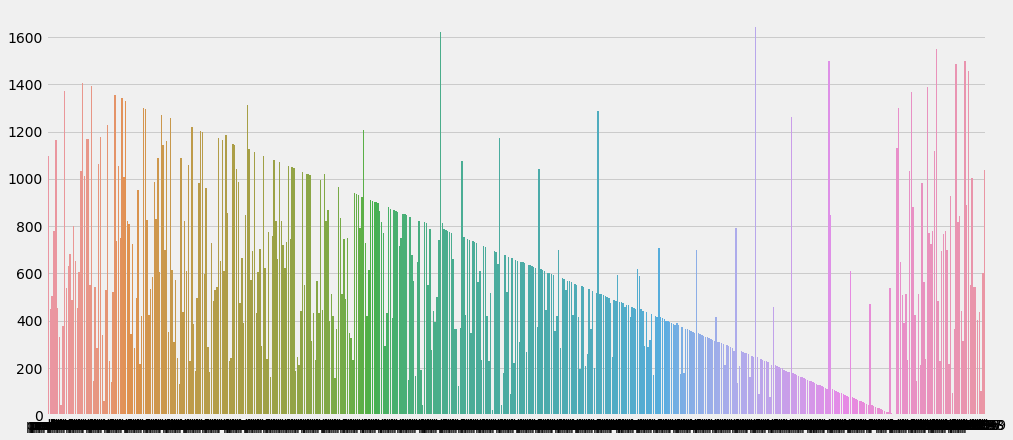

In [12]:
sns.barplot(x=pedestrian, y=pedestrian_sequence_length)

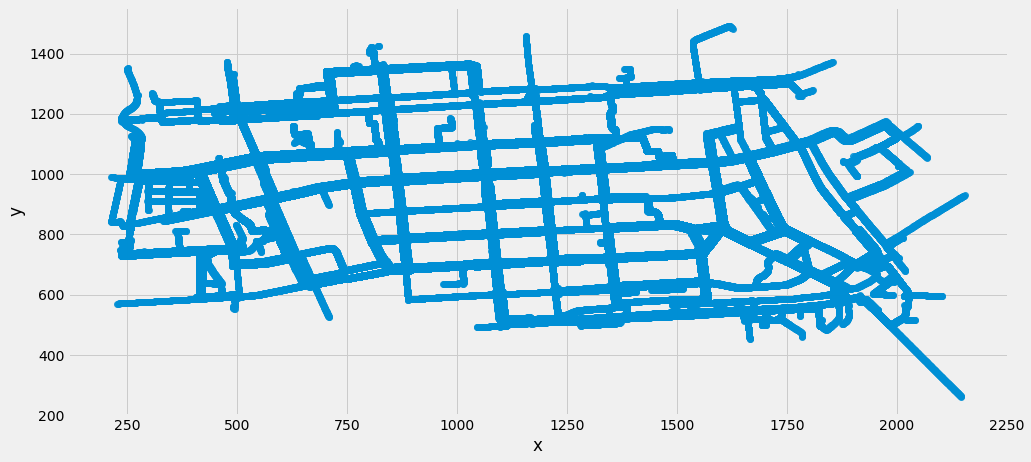

In [13]:
sns.regplot(x="x", y="y", data=output_data, fit_reg=False)

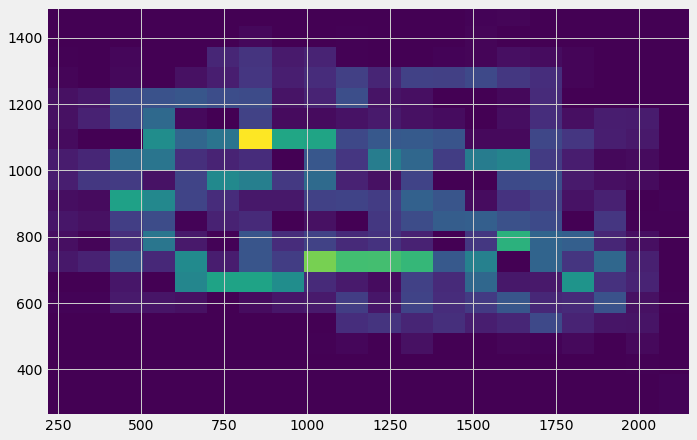

In [14]:
h, _, _, _ = plt.hist2d(output_data["x"], output_data["y"], bins = 20)
plt.imshow(h, origin = "lower", interpolation = "gaussian")

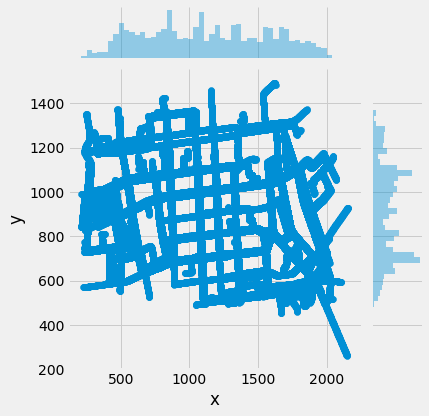

In [15]:
sns.jointplot(x="x", y="y", data=output_data)

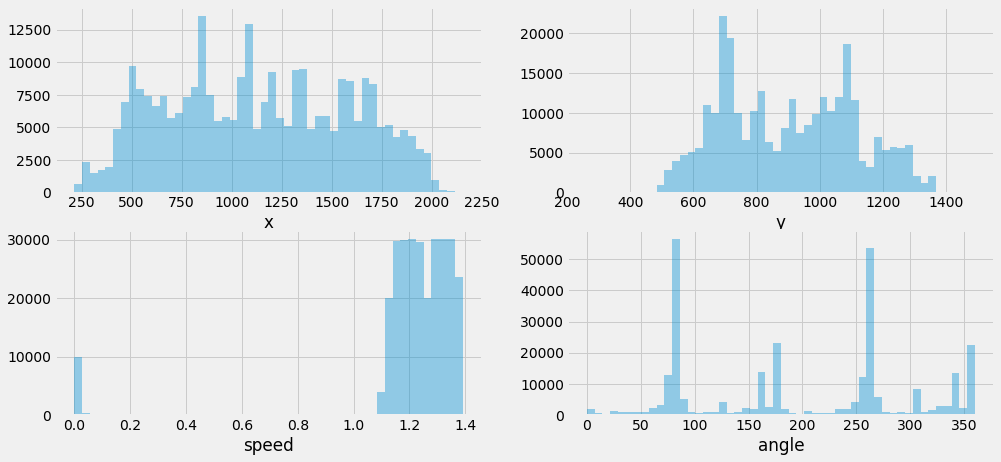

In [16]:
f, axes = plt.subplots(2, 2)
sns.distplot(output_data["x"], kde=False, ax=axes[0, 0])
sns.distplot(output_data["y"], kde=False, ax=axes[0, 1])
sns.distplot(output_data["speed"], kde=False, ax=axes[1, 0])
sns.distplot(output_data["angle"], kde=False, ax=axes[1, 1])

Treating the data as a time series by considering each pedestrian's path individually

In [17]:
ped0 = output_data.loc[output_data['id'] == 'ped0'].drop(columns=["slope"]).reset_index(drop=True).copy(deep=True)
print(ped0.head(100))

    time    id        x       y   angle  speed     pos            edge
0    0.0  ped0  1254.41  722.40   85.74   0.00    0.00     389101374#1
1    1.0  ped0  1255.11  722.09   85.74   0.68    4.33  :4605728249_w0
2    2.0  ped0  1256.30  722.18   85.56   1.19    3.14  :4605728249_w0
3    3.0  ped0  1257.68  722.29   85.56   1.38    1.76  :4605728249_w0
4    4.0  ped0  1258.92  722.39   85.73   1.25    0.51  :4605728249_w0
5    5.0  ped0  1260.29  722.85   85.73   1.38   17.27     389101374#0
6    6.0  ped0  1261.65  722.95   85.73   1.32   15.95     389101374#0
7    7.0  ped0  1262.87  723.04   85.73   1.18   14.77     389101374#0
8    8.0  ped0  1264.16  723.14   85.73   1.26   13.51     389101374#0
9    9.0  ped0  1265.51  723.24   85.73   1.32   12.19     389101374#0
10  10.0  ped0  1266.85  723.34   85.73   1.30   10.90     389101374#0
11  11.0  ped0  1268.13  723.43   85.73   1.25    9.65     389101374#0
12  12.0  ped0  1269.32  723.52   85.73   1.16    8.49     389101374#0
13  13

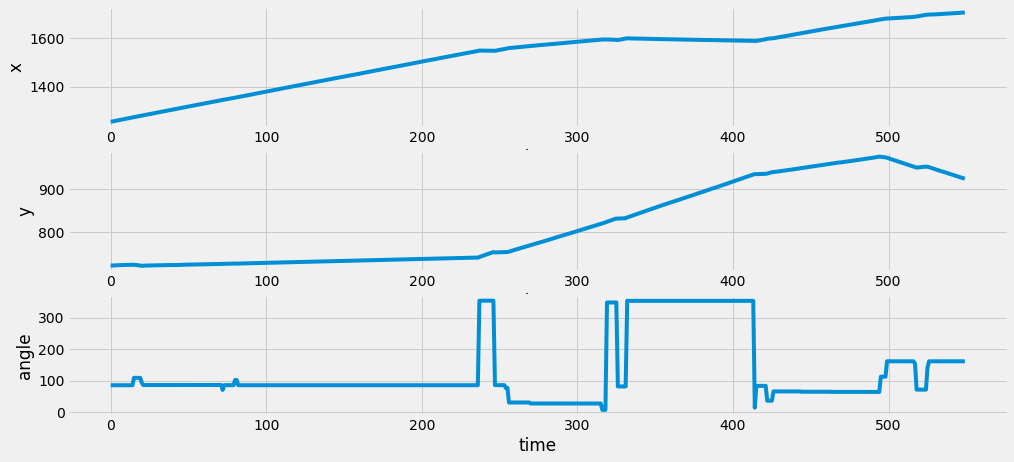

In [18]:
f, axes = plt.subplots(3, 1)
sns.lineplot(x="time", y="x", data=ped0, ax=axes[0])
sns.lineplot(x="time", y="y", data=ped0, ax=axes[1])
sns.lineplot(x="time", y="angle", data=ped0, ax=axes[2])

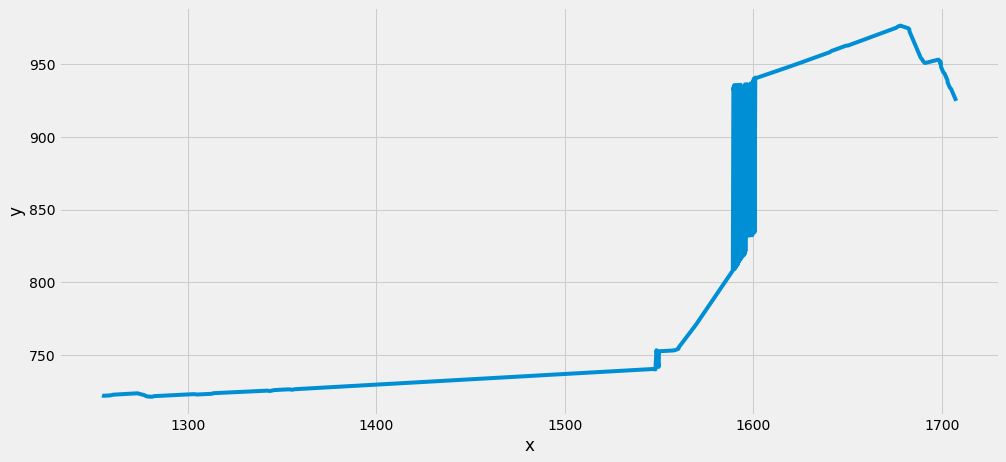

In [19]:
sns.lineplot(x="x", y="y", data=ped0)

Split the pedestrian path into segments during which the pedestrian is walking in a straight line to make processing the data simpler

In [50]:
# Get all points for which the angle is more than 5 degrees
# They represent turning points.
ped_data = output_data.drop(columns=["speed", "slope", "edge", "pos"])
ped_data.sort_values(by=["id", "time"], inplace=True)
ped_data = ped_data.reset_index(drop=True)
print(ped_data)
turning_condition = np.abs(ped_data["angle"].diff(1).fillna(0)) > 5
indices = ped_data.index[turning_condition].tolist()
indices.insert(0, 0)
indices.append(len(ped_data))

          time     id        x       y   angle id_segment
0          0.0   ped0  1254.41  722.40   85.74         _0
1          1.0   ped0  1255.11  722.09   85.74         _0
2          2.0   ped0  1256.30  722.18   85.56         _0
3          3.0   ped0  1257.68  722.29   85.56         _0
4          4.0   ped0  1258.92  722.39   85.73         _0
5          5.0   ped0  1260.29  722.85   85.73         _0
6          6.0   ped0  1261.65  722.95   85.73         _0
7          7.0   ped0  1262.87  723.04   85.73         _0
8          8.0   ped0  1264.16  723.14   85.73         _0
9          9.0   ped0  1265.51  723.24   85.73         _0
10        10.0   ped0  1266.85  723.34   85.73         _0
11        11.0   ped0  1268.13  723.43   85.73         _0
12        12.0   ped0  1269.32  723.52   85.73         _0
13        13.0   ped0  1270.68  723.62   85.73         _0
14        14.0   ped0  1272.07  723.73   85.73         _0
15        15.0   ped0  1273.18  723.81  109.20       _0_1
16        16.0

In [68]:
# We then split the dataframe for the pedestrians at those turning points
# We do that by just add a number next to the id of the pedestrian to be able
# to differentiate each split from the others
count = defaultdict(int)
ped_data["id_segment"] = ""
for i in range(1, len(indices)):
    start = indices[i-1]
    end = indices[i]
    index = count[ped_data.loc[start, "id"]]
    count[ped_data.loc[start, "id"]] += 1
    ped_data.loc[start:end-1, "id_segment"] = ped_data.loc[start:end-1, "id"].apply(lambda x: x + "_{}".format(index))
    # ids = [ped_id + "_{}".format(index) for ped_id in ped_data.loc[start:end-1, "id"].values]
    # ped_data.loc[start:end-1, "id_segment"] = ids
print(ped_data)

          time     id        x       y   angle id_segment
0          0.0   ped0  1254.41  722.40   85.74     ped0_0
1          1.0   ped0  1255.11  722.09   85.74     ped0_0
2          2.0   ped0  1256.30  722.18   85.56     ped0_0
3          3.0   ped0  1257.68  722.29   85.56     ped0_0
4          4.0   ped0  1258.92  722.39   85.73     ped0_0
5          5.0   ped0  1260.29  722.85   85.73     ped0_0
6          6.0   ped0  1261.65  722.95   85.73     ped0_0
7          7.0   ped0  1262.87  723.04   85.73     ped0_0
8          8.0   ped0  1264.16  723.14   85.73     ped0_0
9          9.0   ped0  1265.51  723.24   85.73     ped0_0
10        10.0   ped0  1266.85  723.34   85.73     ped0_0
11        11.0   ped0  1268.13  723.43   85.73     ped0_0
12        12.0   ped0  1269.32  723.52   85.73     ped0_0
13        13.0   ped0  1270.68  723.62   85.73     ped0_0
14        14.0   ped0  1272.07  723.73   85.73     ped0_0
15        15.0   ped0  1273.18  723.81  109.20     ped0_1
16        16.0

#### Stationarity

In [75]:
ped00 = ped_data[ped_data["id_segment"] == "ped1_0"].copy(deep=True)
print(ped00)
# ped00["x"] = np.log(ped00["x"])
# ped00["y"] = np.log(ped00["y"])

      time    id        x        y   angle id_segment
550    4.0  ped1  1156.49  1458.43  176.55     ped1_0
551    5.0  ped1  1156.56  1457.21  176.55     ped1_0
552    6.0  ped1  1156.64  1456.03  176.45     ped1_0
553    7.0  ped1  1156.71  1454.79  176.45     ped1_0
554    8.0  ped1  1156.80  1453.41  176.45     ped1_0
555    9.0  ped1  1156.88  1452.15  176.45     ped1_0
556   10.0  ped1  1156.96  1450.78  176.45     ped1_0
557   11.0  ped1  1157.04  1449.58  176.45     ped1_0
558   12.0  ped1  1157.12  1448.28  176.45     ped1_0
559   13.0  ped1  1157.19  1447.14  176.45     ped1_0
560   14.0  ped1  1157.27  1445.76  176.45     ped1_0
561   15.0  ped1  1157.34  1444.64  176.45     ped1_0
562   16.0  ped1  1157.43  1443.29  176.45     ped1_0
563   17.0  ped1  1157.51  1441.95  176.45     ped1_0
564   18.0  ped1  1157.58  1440.75  176.45     ped1_0
565   19.0  ped1  1157.66  1439.45  176.45     ped1_0
566   20.0  ped1  1157.74  1438.24  176.45     ped1_0
567   21.0  ped1  1157.82  1

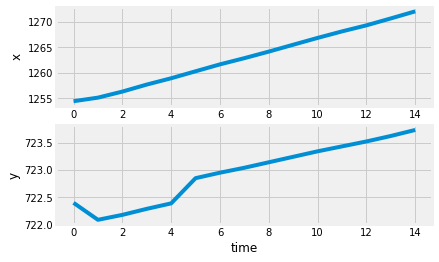

In [70]:
f, axes = plt.subplots(2, 1)
sns.lineplot(x="time", y="x", data=ped00, ax=axes[0])
sns.lineplot(x="time", y="y", data=ped00, ax=axes[1])

In [71]:
ped00["xdiff"] = ped00["x"].diff(1)
ped00["xdiff"].fillna(0, inplace=True)

In [72]:
ped00["ydiff"] = ped00["y"].diff(1)
ped00["ydiff"].fillna(0, inplace=True)

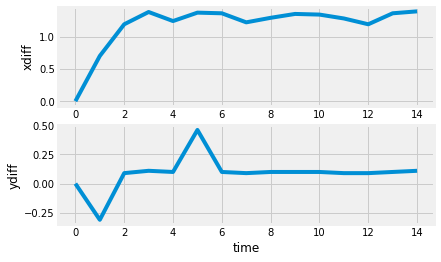

In [73]:
f, axes = plt.subplots(2, 1)
sns.lineplot(x="time", y="xdiff", data=ped00, ax=axes[0])
sns.lineplot(x="time", y="ydiff", data=ped00, ax=axes[1])

## Training

In [174]:
# We compute the first difference and normalize each segment separately
data_list = list()
max_length = 0
for _, segment in ped_data.groupby("id_segment"):
    segment = segment.copy(deep=True).reset_index(drop=True)
    # segment["x"] = np.log(segment["x"])
    # segment["y"] = np.log(segment["y"])
    segment["xdiff"] = segment["x"].diff(1)
    segment["xdiff"].fillna(0, inplace=True)
    segment["ydiff"] = segment["y"].diff(1)
    segment["ydiff"].fillna(0, inplace=True)
    data_input = segment[["xdiff","ydiff"]].values
    data_input = normalize(data_input, axis=0)
    data_input = np.reshape(data_input, (-1, 2))
    data_list.append(data_input)

In [175]:
# We pad the sequences to the length of the longest segment so that we can concatenate them and process them in batches
# We use the value -25.0 to pad the sequences because it is unused and so can be masked easily
pad_value = -25.0
padded_data = pad_sequences(data_list, maxlen=None, dtype="float32", padding="post", value=pad_value)
print(padded_data.shape)

(26, 155, 2)


In [176]:
# We split the data into an input X and an output Y formed by delaying the input by one time step
X = padded_data[:, :-1, :]
Y = padded_data[:, 1:, :]
print(X.shape)
print(Y.shape)

(26, 154, 2)
(26, 154, 2)


In [177]:
# The LSTM architecture
regressor = Sequential()
# Masking layer to mask
regressor.add(Masking(mask_value=pad_value, input_shape=(X.shape[1], X.shape[2])))
# LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True,))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=2))
print(regressor.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_7 (Masking)          (None, 154, 2)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 154, 50)           10600     
_________________________________________________________________
dropout_7 (Dropout)          (None, 154, 50)           0         
_________________________________________________________________
dense_7 (Dense)              (None, 154, 2)            102       
Total params: 10,702
Trainable params: 10,702
Non-trainable params: 0
_________________________________________________________________
None


In [178]:
# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')

In [179]:
# Fitting to the training set
regressor.fit(X, Y, epochs=500, batch_size=16)

Epoch 1/500
26/26 [==============================] - 3s 102ms/step - loss: 1.1967
Epoch 2/500
26/26 [==============================] - 0s 8ms/step - loss: 1.2722
Epoch 3/500
26/26 [==============================] - 0s 8ms/step - loss: 1.2620
Epoch 4/500
26/26 [==============================] - 0s 7ms/step - loss: 1.1596
Epoch 5/500
26/26 [==============================] - 0s 8ms/step - loss: 1.1588
Epoch 6/500
26/26 [==============================] - 0s 8ms/step - loss: 1.1708
Epoch 7/500
26/26 [==============================] - ETA: 0s - loss: 1.773 - 0s 8ms/step - loss: 1.3711
Epoch 8/500
26/26 [==============================] - 0s 8ms/step - loss: 1.3232
Epoch 9/500
26/26 [==============================] - 0s 8ms/step - loss: 1.2576
Epoch 10/500
26/26 [==============================] - 0s 8ms/step - loss: 1.3415
Epoch 11/500
26/26 [==============================] - 0s 8ms/step - loss: 1.3139
Epoch 12/500
26/26 [==============================] - 0s 8ms/step - loss: 1.1800
Epoch 13/50

26/26 [==============================] - 0s 8ms/step - loss: 0.9836
Epoch 102/500
26/26 [==============================] - 0s 9ms/step - loss: 0.9962
Epoch 103/500
26/26 [==============================] - 0s 8ms/step - loss: 0.9798
Epoch 104/500
26/26 [==============================] - 0s 9ms/step - loss: 0.9780
Epoch 105/500
26/26 [==============================] - 0s 9ms/step - loss: 1.0096
Epoch 106/500
26/26 [==============================] - 0s 8ms/step - loss: 0.9986
Epoch 107/500
26/26 [==============================] - 0s 8ms/step - loss: 1.2431
Epoch 108/500
26/26 [==============================] - 0s 8ms/step - loss: 1.0142
Epoch 109/500
26/26 [==============================] - 0s 8ms/step - loss: 1.1265
Epoch 110/500
26/26 [==============================] - 0s 9ms/step - loss: 1.1221
Epoch 111/500
26/26 [==============================] - 0s 10ms/step - loss: 1.4449
Epoch 112/500
26/26 [==============================] - 0s 9ms/step - loss: 0.9969
Epoch 113/500
26/26 [========

26/26 [==============================] - 0s 7ms/step - loss: 1.1149
Epoch 202/500
26/26 [==============================] - 0s 7ms/step - loss: 1.1403
Epoch 203/500
26/26 [==============================] - 0s 8ms/step - loss: 1.3893
Epoch 204/500
26/26 [==============================] - 0s 8ms/step - loss: 1.0512
Epoch 205/500
26/26 [==============================] - 0s 8ms/step - loss: 1.3773
Epoch 206/500
26/26 [==============================] - 0s 7ms/step - loss: 1.4177
Epoch 207/500
26/26 [==============================] - 0s 7ms/step - loss: 0.9685
Epoch 208/500
26/26 [==============================] - 0s 8ms/step - loss: 1.3601
Epoch 209/500
26/26 [==============================] - 0s 7ms/step - loss: 0.9453
Epoch 210/500
26/26 [==============================] - 0s 8ms/step - loss: 1.0150
Epoch 211/500
26/26 [==============================] - 0s 7ms/step - loss: 0.9409
Epoch 212/500
26/26 [==============================] - 0s 8ms/step - loss: 0.9521
Epoch 213/500
26/26 [=========

26/26 [==============================] - 0s 7ms/step - loss: 1.1208
Epoch 302/500
26/26 [==============================] - 0s 8ms/step - loss: 0.9480
Epoch 303/500
26/26 [==============================] - 0s 7ms/step - loss: 1.7261
Epoch 304/500
26/26 [==============================] - 0s 7ms/step - loss: 0.9481
Epoch 305/500
26/26 [==============================] - 0s 8ms/step - loss: 0.8575
Epoch 306/500
26/26 [==============================] - 0s 7ms/step - loss: 0.9425
Epoch 307/500
26/26 [==============================] - 0s 7ms/step - loss: 0.9421
Epoch 308/500
26/26 [==============================] - 0s 8ms/step - loss: 0.9651
Epoch 309/500
26/26 [==============================] - 0s 7ms/step - loss: 0.9201
Epoch 310/500
26/26 [==============================] - 0s 7ms/step - loss: 0.9348
Epoch 311/500
26/26 [==============================] - 0s 7ms/step - loss: 1.5269
Epoch 312/500
26/26 [==============================] - 0s 7ms/step - loss: 0.8749
Epoch 313/500
26/26 [=========

26/26 [==============================] - 0s 8ms/step - loss: 1.3087
Epoch 402/500
26/26 [==============================] - 0s 8ms/step - loss: 1.8303
Epoch 403/500
26/26 [==============================] - 0s 9ms/step - loss: 0.9725
Epoch 404/500
26/26 [==============================] - 0s 9ms/step - loss: 1.2796
Epoch 405/500
26/26 [==============================] - 0s 11ms/step - loss: 1.3319
Epoch 406/500
26/26 [==============================] - 0s 9ms/step - loss: 1.1832
Epoch 407/500
26/26 [==============================] - 0s 8ms/step - loss: 1.2684
Epoch 408/500
26/26 [==============================] - 0s 8ms/step - loss: 2.0762
Epoch 409/500
26/26 [==============================] - 0s 9ms/step - loss: 1.2470
Epoch 410/500
26/26 [==============================] - 0s 9ms/step - loss: 1.1410
Epoch 411/500
26/26 [==============================] - 0s 9ms/step - loss: 1.0701
Epoch 412/500
26/26 [==============================] - 0s 9ms/step - loss: 0.9818
Epoch 413/500
26/26 [========

26/26 [==============================] - 0s 8ms/step - loss: 0.8117


In [180]:
predicted = regressor.predict(X[0:1])
mask = X[0:1] != -5.0
predicted = predicted[mask].reshape(1, -1, 2)
print(predicted)

[[[-0.1924711  -0.23096237]
  [-0.3269438  -0.45380038]
  [-0.19613889 -0.34801644]
  [-0.06487506 -0.23120707]
  [ 0.04048561 -0.12994644]
  [ 0.23773499  0.13957414]
  [ 0.18570714  0.08653447]
  [ 0.114195    0.01554939]
  [ 0.01824257 -0.08420032]
  [-0.12053305 -0.23371348]
  [-0.335078   -0.46530706]
  [-0.7232804  -0.87972724]
  [-1.578091   -1.7671742 ]
  [-3.8599057  -4.091867  ]
  [-6.297168   -6.5445848 ]]]


In [181]:
true_value = Y[0:1][mask].reshape(1, -1, 2)
print(true_value)

[[[ 0.14698164 -0.4759104 ]
  [ 0.2498688   0.13816753]
  [ 0.2897638   0.16887143]
  [ 0.26036748  0.15351948]
  [ 0.2876641   0.7061896 ]
  [ 0.28556433  0.15351948]
  [ 0.256168    0.13816753]
  [ 0.2708662   0.15351948]
  [ 0.2834646   0.15351948]
  [ 0.28136486  0.15351948]
  [ 0.26876643  0.13816753]
  [ 0.2498688   0.13816753]
  [ 0.28556433  0.15351948]
  [ 0.29186356  0.16887143]
  [-5.         -5.        ]]]


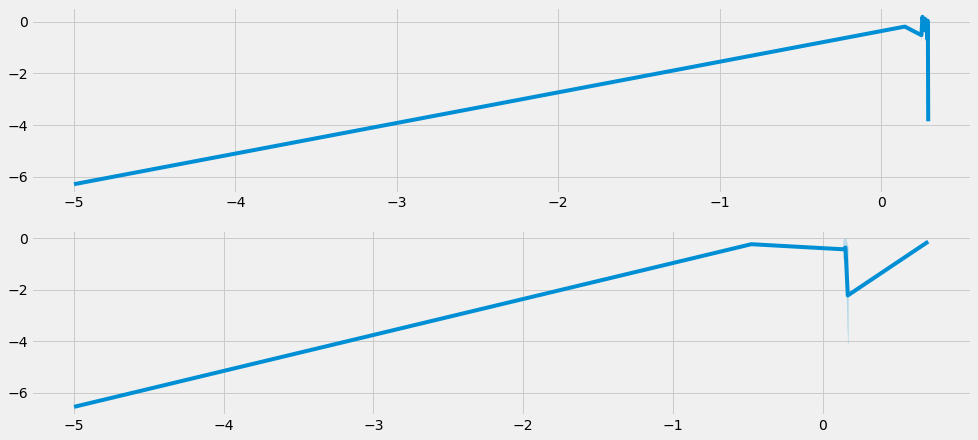

In [182]:
f, axes = plt.subplots(2, 1)
sns.lineplot(x=true_value[0, :, 0], y=true_value[0, :, 1], ax=axes[0])
sns.lineplot(x=predicted[0, :, 0], y=predicted[0, :, 1], ax=axes[1])